In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from gengraph import EpsimGraph
from epsim import Epsim

In [2]:
# Simple run

starttime = time.time()
epsim_graph = EpsimGraph(k=100000, sigma_office=0.5, perc_split_classes=0.5)
sim = Epsim()
sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard, epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
sim.run_sim(sim_iters=500, p_spread_family=0.37, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5,
            p_testing=0.5, print_progress=True, export_csv='csv/p1_0.37_p2_0.2.csv')
print('runtime: {}s'.format(time.time() - starttime))

22, 5, 6, 22, 1872]	[10, 6, 6, 6, 0]
88:	[236693, 16, 22, 5, 6, 1898]	[8, 5, 3, 4, 0]
89:	[236687, 6, 16, 22, 5, 1904]	[6, 0, 0, 2, 0]
90:	[236672, 15, 6, 16, 22, 1909]	[15, 0, 0, 2, 0]
91:	[236620, 22, 10, 4, 10, 1974]	[13, 10, 6, 18, 36]
92:	[236598, 16, 22, 10, 4, 1990]	[9, 5, 2, 6, 0]
93:	[236593, 2, 12, 21, 7, 2005]	[2, 0, 1, 2, 15]
94:	[236561, 27, 2, 12, 21, 2017]	[13, 10, 4, 5, 0]
95:	[236513, 35, 27, 2, 12, 2051]	[20, 13, 2, 13, 0]
96:	[236509, 4, 35, 27, 2, 2063]	[4, 0, 0, 5, 0]
97:	[236491, 18, 4, 35, 27, 2065]	[18, 0, 0, 5, 0]
98:	[236430, 15, 12, 2, 14, 2167]	[18, 5, 4, 13, 91]
99:	[236423, 5, 15, 12, 2, 2183]	[2, 1, 2, 2, 0]
100:	[236417, 3, 5, 13, 6, 2196]	[4, 1, 1, 0, 13]
101:	[236392, 17, 3, 5, 13, 2210]	[7, 7, 3, 8, 0]
102:	[236360, 24, 17, 3, 5, 2231]	[13, 6, 5, 8, 0]
103:	[236357, 3, 24, 17, 3, 2236]	[3, 0, 0, 6, 0]
104:	[236346, 11, 3, 24, 17, 2239]	[11, 0, 0, 6, 0]
105:	[236302, 26, 11, 1, 12, 2288]	[14, 12, 3, 9, 39]
106:	[236295, 5, 26, 11, 1, 2302]	[4, 0, 1, 2,

In [2]:
# Multiple runs per parameter combination
num_runs = 100

sim_iters = 500
k = 100000
sigma_office_vals = [0.5]
p_spread_family_vals = [0.3]
p_spread_school_office_vals = [0.2]
p_detect_child_vals = [0.2]
p_detect_parent_vals = [0.5]
p_testing_vals = [0.5]
perc_split_classes_vals = [0.5]

runs_per_param_combi = {}
for sigma_office in sigma_office_vals:
    for p_spread_family in p_spread_family_vals:
        for p_spread_school_office in p_spread_school_office_vals:
            for p_detect_child in p_detect_child_vals:
                for p_detect_parent in p_detect_parent_vals:
                    for p_testing in p_testing_vals:
                        for perc_split_classes in perc_split_classes_vals:
                            runs = []
                            for i in range(num_runs):
                                epsim_graph = EpsimGraph(k, sigma_office, perc_split_classes)
                                sim = Epsim()
                                sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard, epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
                                sim_res = sim.run_sim(sim_iters, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing)
                                runs.append(sim_res[1])
                                param_combi = (sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent,
                                               p_testing, p_spread_school_office)
                            runs_per_param_combi[param_combi] = runs

pickle.dump(runs_per_param_combi, open('runs_per_param_combi.p', 'wb'))

lasses
infected nodes: 358

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
	50000 children in split classes and 50000 children in standard classes (100000 total, break: 2000)
parents: cluster 1-sigma_office no change, sigma_office*1/2 cluster 2 nodes, sigma_office*1/4 cluster 3 nodes, sigma_office*1/8 cluster 4 nodes, sigma_office*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5 p_testing=0.5
50000 children in split classes and 50000 children in standard classes
infected nodes: 9665

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that th

(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)
(0.5, 0.3, 0.2, 0.2, 0.5, 0.5, 0.2)


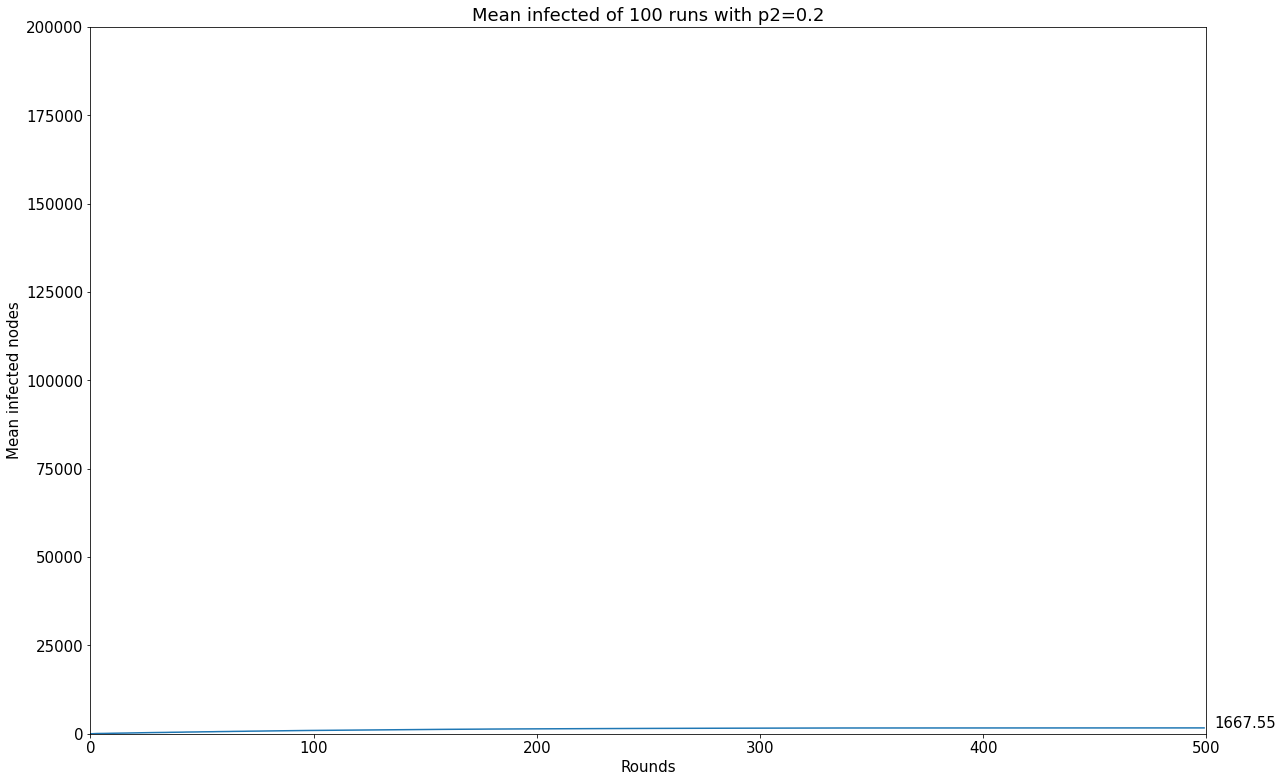

In [3]:
# Plot mean infections per round for all runs

plt.rcParams.update({'font.size': 15})

print('(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)')
for param_combi, runs in runs_per_param_combi.items():
    print(param_combi)
    infecs_per_runs_per_rounds = zip(*runs)
    mean_infecs_per_round = [np.mean(infecs_per_runs) for infecs_per_runs in infecs_per_runs_per_rounds]
    fig, axs = plt.subplots(figsize=(20,13))
    fig.patch.set_facecolor('xkcd:white')
    axs.set_ylim(top=200000)
    axs.set_xlim(0, sim_iters)
    axs.plot(range(sim_iters), mean_infecs_per_round)
    plt.annotate(max(mean_infecs_per_round), xy=(1, max(mean_infecs_per_round)), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    axs.set_title('Mean infected of 100 runs with p2=0.2')
    axs.set_xlabel('Rounds')
    axs.set_ylabel('Mean infected nodes')

(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)
(0.5, 0.3, 0.2, 0.2, 0.5, 0.5, 0.2)


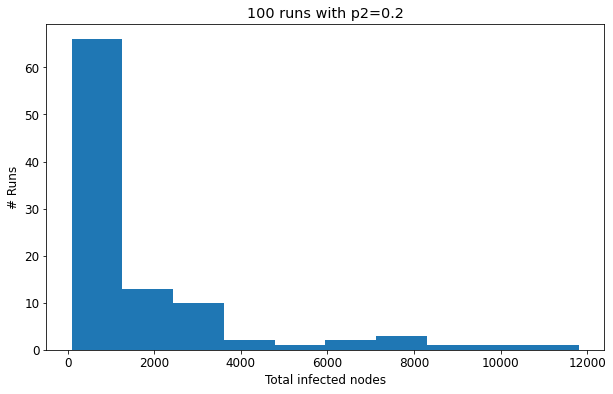

In [4]:
# Plot histogram of total infections for all runs

plt.rcParams.update({'font.size': 12})

print('(sigma_office, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing, p_spread_school_office)')
for param_combi, runs in runs_per_param_combi.items():
    print(param_combi)
    total_infec_per_run = [max(run) for run in runs]
    fig, axs = plt.subplots(figsize=(10,6))
    fig.patch.set_facecolor('xkcd:white')
    axs.set_title('100 runs with p2=0.2')
    axs.set_xlabel('Total infected nodes')
    axs.set_ylabel('# Runs')
    axs.hist(total_infec_per_run)

In [2]:
# Run with various parameters

sim_iters = 500
k = 100000
sigma_office_vals = [0.5]
p_spread_family_vals = [0.3, 0.37]
p_spread_school_office_vals = [0.2, 0.22, 0.24]
p_detect_child_vals = [0.2]
p_detect_parent_vals = [0.5]
p_testing_vals = [0.5]
perc_split_classes = 0.5

results = {}

starttime = time.time()
for sigma_office in sigma_office_vals:
    epsim_graph = EpsimGraph(k, sigma_office, perc_split_classes)
    sim = Epsim()
    sim.init_from_dicts(epsim_graph.family_nbrs, epsim_graph.school_nbrs_standard, epsim_graph.school_nbrs_split, epsim_graph.office_nbrs)
    for p_spread_family in p_spread_family_vals:
        for p_detect_child in p_detect_child_vals:
            for p_detect_parent in p_detect_parent_vals:
                for p_testing in p_testing_vals:
                    for p_spread_school_office in p_spread_school_office_vals:
                        sim_res = sim.run_sim(sim_iters, p_spread_family, p_spread_school_office, p_detect_child, p_detect_parent, p_testing,
                                            export_csv='csv/p1_{}_p2_{}.csv'.format(p_spread_family, p_spread_school_office))
                        results[sigma_office, p_spread_family, p_detect_child, p_detect_parent, p_testing, p_spread_school_office] = sim_res

print('runtime: {}s'.format(time.time() - starttime))

creating graph with k=100000, sigma_office=0.5
randomly cluster children and parent nodes, such that there are child-parent pairs
parents: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
parents: duplicate every node
children: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
	50000 children in split classes and 50000 children in standard classes (100000 total, break: 2000)
parents: cluster 1-sigma_office no change, sigma_office*1/2 cluster 2 nodes, sigma_office*1/4 cluster 3 nodes, sigma_office*1/8 cluster 4 nodes, sigma_office*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_school_office=0.2, p_detect_child=0.2, p_detect_parent=0.5 p_testing=0.5
50000 children in split classes and 50000 children in standard classes
infected nodes: 347

starting simulation with n=238640, num_start_nodes=24, sim_iters=500
p_spread_family=0.3, p_spread_school_office=0.22, p_detect_chil

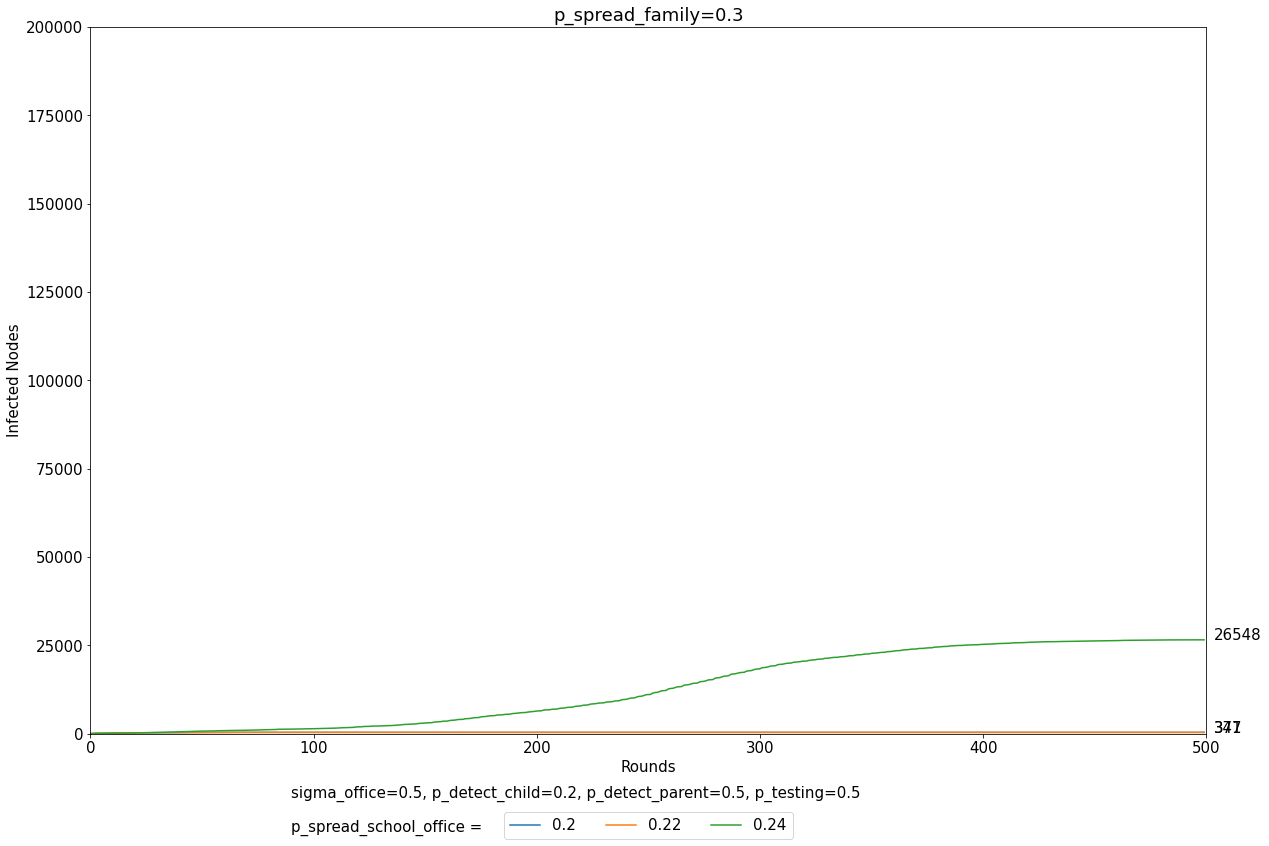

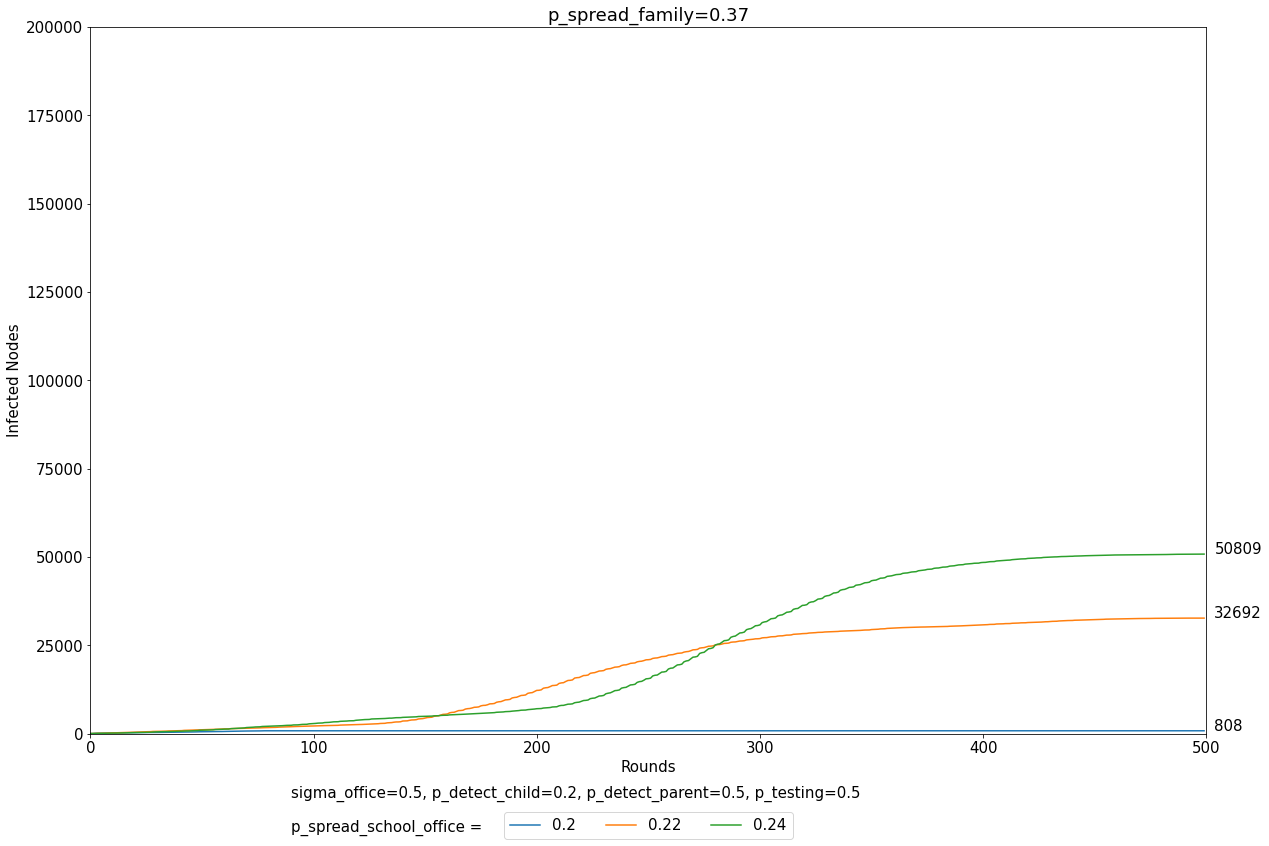

In [4]:
# Plot various parameter runs

plt.rcParams.update({'font.size': 15})

for sigma_office in sigma_office_vals:
    for p_spread_family in p_spread_family_vals:
        for p_detect_child in p_detect_child_vals:
            for p_detect_parent in p_detect_parent_vals:
                for p_testing in p_testing_vals:
                    fig, axs = plt.subplots(figsize=(20,13))
                    fig.patch.set_facecolor('xkcd:white')
                    axs.set_ylim(top=200000)
                    axs.set_xlim(0, sim_iters)
                    for p_spread_school_office in p_spread_school_office_vals:
                        result = results[sigma_office, p_spread_family, p_detect_child, p_detect_parent, p_testing, p_spread_school_office]
                        axs.plot(result[0], result[1], label=p_spread_school_office)
                        plt.annotate(max(result[1]), xy=(1, max(result[1])), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
                    axs.set_title('p_spread_family={}'.format(p_spread_family))
                    axs.set_xlabel('Rounds')
                    axs.set_ylabel('Infected Nodes')
                    axs.text(0.18, -0.09, 'sigma_office={}, p_detect_child={}, p_detect_parent={}, p_testing={}'.format(
                        sigma_office, p_detect_child, p_detect_parent, p_testing), transform=axs.transAxes)
                    axs.text(0.18, -0.138, 'p_spread_school_office =', transform=axs.transAxes)                   
                    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)